# 1) Introduction: The Crime Analysis task



Crime prediction is a growing field that aims to use data-driven approaches to anticipate and reduce criminal activities . By analyzing patterns in historical data, authorities can allocate resources more effectively(Feng et al., 2019). This Approach also improve public safety, and address insurance companies, social issues on a larger scale. This project focuses on analyzing crime trends in the UK to gain actionable insights.This analysis also helps companies related to insurance improve risk models, set fair premiums, and use resources wisely to handle crime-related risks.

The study uses the Street-Level Crime Data from the UK Home Office, which contains 19 million rows detailing crimes and their locations (latitude and longitude). To enhance the dataset, additional geographical information such as LSOA codes and transformed location data were included.

To handle the complexity and volume of the data,Azure Cloud services was used. Apache Spark was deployed on an Azure Virtual Machine (VM) as an Infrastructure-as-a-Service  platform (Shaikh et al., 2019). This was efficient in distributed processing. For further analysis and visualizations, Google Colab was utilized as a Software-as-a-Service = platform .

**The key objectives are:**



Analyze whether violent crimes are on the rise, declining, or remaining steady over time using spark and cloud computing.
Evaluate if Liverpool has more firearm incidents per head compared to other cities in the UK using spark and cloud computing.
with spark and cloud computing,Explore the relationship between firearm incidents and drug offenses to identify any connections.

Toolsused:
Big data tools such as Spark, Pandas, and Statsmodels were used for processing, analysis, and visualization(Mohammed et al., 2022). Advanced methods like ARIMA modeling and graphs were applied,
(Mehrmolaei and Keyvanpour, 2016) . This methodology aims to provide valuable insights for policymakers and law enforcement.

# 2) Component Selection and Data Pipeline Implementation



**Component Selection**
To process and analyze the large dataset, the following infrastructure and tools were selected:

**Infrastructure:**

Azure VM: An IaaS platform deployed to handle Apache Spark's computational demands, using Standard D4s v3 (4 vCPUs, 16 GiB RAM).

**Google Colab:** A SaaS platform used for visualization and final outputs.

**Libraries:**

**Apache PySpark:** A distributed framework for efficient large-scale data processing (Shaikh et al., 2019). Spark SQL enabled streamlined data filtering and extraction **SparkSession **managed resources and optimized performance for processing tasks.

**Pandas:** A Python library used for data manipulation and analysis after initial processing in Spark.

**Matplotlib** and Seaborn: Visualization libraries utilized for creating trend graphs, pie charts, and scatterplots.

**Statsmodels (ARIMA):** Applied for time series analysis and forecasting(Mehrmolaei and Keyvanpour, 2016).

**NumPy:** Essential for numerical computations within statistical and machine learning models.
Data Handling:

The initial dataset was provided in CSV format, containing crime data with over 19 million rows.
For testing, a sample dataset containing 10% of the rows was used to validate code functionality. Once validated, the full dataset was loaded for comprehensive analysis.
Spark’s distributed capabilities allowed efficient processing of both sample and full datasets.
This comprehensive setup made the infrastructure and tools met the project’s objectives while maintaining scalability, efficiency, and accuracy (Shaikh et al., 2019).



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install required packages
!pip install pyspark
!pip install statsmodels

# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql.functions import col, count, when, lit, sum, to_date, year, rlike, regexp_replace, expr, broadcast

# Statsmodels imports
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Pandas and NumPy imports
import pandas as pd
import numpy as np

# Matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


In [ ]:
spark = SparkSession.builder \
    .appName("BigDataWeaponsDrugsAnalysis") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

# 3) Data Extraction and Filtering

**Data Extraction and Filtering for Evidence**

Simple methods were used to clean and analyze the data to prove three points: trends in violent crime, firearm incidents in Liverpool, and the link between firearms and drug crimes. For fast and efficient processing, techniques like caching, repartitioning, and unpersisting were applied (Ahmed et al., 2020).

**Data preparation for Trends in Violent Crime**
To determine if violent crimes are increasing, decreasing, or stable, Spark was used to process the data. Column names were cleaned to remove spaces, and a new column called violent_crime_trend was added to violent_crime_trend. The data was grouped by year for time series analysis using ARIMA, which has been recognized for its effectiveness in trend analysis and forecasting (Feng et al., 2019).

**Data preparation for Firearm Incidents Per Head in Liverpoo**l
To find out if Liverpool has the highest firearm incidents per person, rows with Crime_type as "possession of weapons" and Last_outcome_category as "offender sent to prison" were filtered. The filtered data was combined with population data to calculate incidents per head.joins were used (Ahmed et al., 2020).

** Data preparation for Firearms and Drug Crimes**
To explore the connection between firearms and drug crimes, rows with Crime_type as "Drugs" were matched with firearm incidents. The counts were grouped by LSOA_code.

**Diagnosis** :population check using all the factors was used as diagnosis for population consistency across columns.

**Fast and Efficient Processing**

Caching, repartitioning, and unpersisting confirm fast and memory-efficient analysis. These techniques are widely used for handling large datasets in a big data environment and optimizing performance (Ahmed et al., 2020).

In [ ]:
 #Load the Datasets
crime_data_path = "/content/drive/My Drive/Bigdata/all_crimes21_hdr.txt.gz"
lsoa_data_path = "/content/drive/My Drive/Bigdata/LSOA_pop_v2.csv"

from pyspark.sql.functions import col, year, to_date, when
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType

# Define Schemas
crime_schema = StructType([
    StructField("Crime_ID", StringType(), True),
    StructField("Month", StringType(), True),
    StructField("Reported_by", StringType(), True),
    StructField("Falls_within", StringType(), True),
    StructField("Longitude", FloatType(), True),
    StructField("Latitude", FloatType(), True),
    StructField("Location", StringType(), True),
    StructField("LSOA_code", StringType(), True),
    StructField("LSOA_name", StringType(), True),
    StructField("Crime_type", StringType(), True),
    StructField("Last_outcome_category", StringType(), True),
    StructField("Context", StringType(), True)
])

lsoa_schema = StructType([
    StructField("date", IntegerType(), True),
    StructField("geography", StringType(), True),
    StructField("geography_code", StringType(), True),
    StructField("Rural_Urban", StringType(), True),
    StructField("Variable_All_usual_residents_measures_Value", IntegerType(), True),
    StructField("Variable_Males_measures_Value", IntegerType(), True),
    StructField("Variable_Females_measures_Value", IntegerType(), True),
    StructField("Variable_Lives_in_a_household_measures_Value", IntegerType(), True),
    StructField("Variable_Lives_in_a_communal_establishment_measures_Value", IntegerType(), True),
    StructField("Variable_Schoolchild_or_full_time_student_aged_4_and_over_at_their_non_term_time_address_measures_Value", IntegerType(), True),
    StructField("Variable_Area_Hectares_measures_Value", FloatType(), True),
    StructField("Variable_Density_number_of_persons_per_hectare_measures_Value", FloatType(), True)
])

# Load Data
crime_df = spark.read.csv(
    crime_data_path,
    schema=crime_schema,
    header=True
).withColumn(
    "Year", year(to_date(col("Month"), "yyyy-MM"))
)

# Add a new column "violent_crime_trend" based on "Crime_type"
crime_df = crime_df.withColumn(
    "violent_crime_trend",
    when(col("Crime_type").rlike("(?i)violen"), col("Crime_type")).otherwise(None)
)

lsoa_df = spark.read.csv(lsoa_data_path, schema=lsoa_schema, header=True)

# Display Sample Data
print("Crime Data Sample:")
crime_df.show(5)

print("LSOA Data Sample:")
lsoa_df.show(5)

# Clean and standardize the geography column by removing last 4 characters
lsoa_df = lsoa_df.withColumn("geography", expr("substring(geography, 1, length(geography) - 4)"))


Crime Data Sample:
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+----+-------------------+
|Crime_ID|  Month|         Reported_by|        Falls_within|Longitude| Latitude|            Location|LSOA_code|           LSOA_name|          Crime_type|Last_outcome_category|Context|Year|violent_crime_trend|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+----+-------------------+
|    NULL|2010-12|Avon and Somerset...|Avon and Somerset...|  -0.8056| 51.81914|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|                 NULL|   NULL|2010|               NULL|
|    NULL|2010-12|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418167|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social b

In [ ]:
crime_df.cache()

lsoa_df.show(5)

lsoa_df = lsoa_df.withColumn(
    "Calculated Population",
    (col("Variable_Area_Hectares_measures_Value") * col("Variable_Density_number_of_persons_per_hectare_measures_Value")).cast(IntegerType())
)

# Group by geography and sum the calculated population
grouped_population_df = lsoa_df.groupBy("geography").agg(
    sum("Calculated Population").alias("Total Calculated Population")
)

print("Grouped Population Data:")
grouped_population_df.show(10)




+----+-----------+--------------+-----------+-------------------------------------------+-----------------------------+-------------------------------+--------------------------------------------+---------------------------------------------------------+-------------------------------------------------------------------------------------------------------+-------------------------------------+-------------------------------------------------------------+
|date|  geography|geography_code|Rural_Urban|Variable_All_usual_residents_measures_Value|Variable_Males_measures_Value|Variable_Females_measures_Value|Variable_Lives_in_a_household_measures_Value|Variable_Lives_in_a_communal_establishment_measures_Value|Variable_Schoolchild_or_full_time_student_aged_4_and_over_at_their_non_term_time_address_measures_Value|Variable_Area_Hectares_measures_Value|Variable_Density_number_of_persons_per_hectare_measures_Value|
+----+-----------+--------------+-----------+-------------------------------------

In [ ]:


# 1. Calculate Population Using Area x Density
lsoa_df = lsoa_df.withColumn(
    "Population_AreaDensity",
    (col("Variable_Area_Hectares_measures_Value") *
     col("Variable_Density_number_of_persons_per_hectare_measures_Value")).cast(IntegerType())
)

# 2. Calculate Population Using Male + Female
lsoa_df = lsoa_df.withColumn(
    "Population_GenderSum",
    (col("Variable_Males_measures_Value") +
     col("Variable_Females_measures_Value")).cast(IntegerType())
)

# 3. Population Using Total Residents
lsoa_df = lsoa_df.withColumnRenamed(
    "Variable_All_usual_residents_measures_Value",
    "Population_TotalResidents"
)

# Group by geography (City) and sum up population calculations
population_comparison_df = lsoa_df.groupBy("geography").agg(
    sum("Population_AreaDensity").alias("Total_Population_AreaDensity"),
    sum("Population_GenderSum").alias("Total_Population_GenderSum"),
    sum("Population_TotalResidents").alias("Total_Population_TotalResidents")
)


population_comparison_df.show(5)


+--------------------+----------------------------+--------------------------+-------------------------------+
|           geography|Total_Population_AreaDensity|Total_Population_GenderSum|Total_Population_TotalResidents|
+--------------------+----------------------------+--------------------------+-------------------------------+
|     Northumberland |                      307835|                    316028|                         316028|
|      Cannock Chase |                       97488|                     97462|                          97462|
|Nuneaton and Bedw...|                      125280|                    125252|                         125252|
|          Stockport |                      283118|                    283275|                         283275|
|             Barnet |                      356278|                    356386|                         356386|
+--------------------+----------------------------+--------------------------+-------------------------------+
o

In [ ]:
#violent_crime by year
violent_by_year = crime_df.filter(col("violent_crime_trend").isNotNull()) \
    .repartition(200)  \
    .groupBy("Year") \
    .agg(count("Crime_ID").alias("Total Violent Crimes")) \
    .orderBy("Year")

violent_by_year.show(20)

+----+--------------------+
|Year|Total Violent Crimes|
+----+--------------------+
|2010|                1067|
|2011|              111285|
|2012|              670061|
|2013|              680559|
|2014|              831852|
|2015|             1040969|
|2016|             1231351|
|2017|             1500906|
|2018|             1764153|
|2019|             1870222|
|2020|             1855750|
|2021|              765819|
+----+--------------------+



In [ ]:
# Step 5: Calculate Firearm Incidents Per Head for Liverpool
firearm_incidents = crime_df.filter(
    (col("Crime_type").rlike("(?i).*possession.*weapon.*")) &
    (col("Last_outcome_category").rlike("(?i).*offender sent to prison.*"))
)



In [ ]:

# 1. Select only necessary columns before the join
firearm_incidents = firearm_incidents.select("LSOA_code", "Crime_ID")
lsoa_df = lsoa_df.select("geography_code", "geography")

# 2. Perform the join
firearm_with_population = firearm_incidents.join(
    lsoa_df,
    firearm_incidents["LSOA_code"] == lsoa_df["geography_code"],
    "inner"
)

# 3. Repartition before groupBy and agg
firearm_with_population = firearm_with_population.repartition(10) # Adjust partition number

# 4. Perform groupBy and agg
firearm_with_population = firearm_with_population.groupBy("geography").agg(
    count("Crime_ID").alias("Firearm Incidents")
)

firearm_with_population.show(20)


+--------------------+-----------------+
|           geography|Firearm Incidents|
+--------------------+-----------------+
|     Northumberland |               48|
|      Cannock Chase |               19|
|Nuneaton and Bedw...|               28|
|             Barnet |               43|
|          Stockport |               23|
|              Leeds |              203|
|      South Holland |               11|
|             Oldham |               58|
|           Lewisham |               97|
|    Huntingdonshire |               10|
|           Bradford |              122|
|       Forest Heath |                4|
|            Norwich |               66|
|Kensington and Ch...|               57|
|              Luton |               77|
|             Exeter |               36|
|          Liverpool |              170|
|            Salford |               72|
|          Maidstone |               26|
|         Winchester |                9|
+--------------------+-----------------+
only showing top

In [ ]:


# Cache the DataFrames
firearm_with_population.cache()
grouped_population_df.cache()

# Perform a broadcast join
firearm_incidents_per_city = firearm_with_population.join(
    broadcast(grouped_population_df),  # Use broadcast here
    firearm_with_population["geography"] == grouped_population_df["geography"],
    "inner"
).select(
    firearm_with_population["geography"],
    col("Firearm Incidents"),
    col("Total Calculated Population").alias("Total Population"),
    (col("Firearm Incidents") / col("Total Calculated Population")).alias("Incidents per Head")
)

print("Firearm Incidents Per City:")
firearm_incidents_per_city.show()

# Unpersist the DataFrames
firearm_with_population.unpersist()
grouped_population_df.unpersist()

from pyspark.sql.functions import col

# Repartition the DataFrame on the "geography" column
firearm_incidents_per_city = firearm_incidents_per_city.repartition(col("geography"))

# Cache the repartitioned DataFrame
firearm_incidents_per_city.cache()



Firearm Incidents Per City:
+--------------------+-----------------+----------------+--------------------+
|           geography|Firearm Incidents|Total Population|  Incidents per Head|
+--------------------+-----------------+----------------+--------------------+
|     Northumberland |               48|          307835|1.559276885344421...|
|      Cannock Chase |               19|           97488|1.948957820449696...|
|Nuneaton and Bedw...|               28|          125280|2.234993614303959...|
|             Barnet |               43|          356278|1.206922683971505...|
|          Stockport |               23|          283118| 8.12382116290734E-5|
|              Leeds |              203|          751305|2.701965247136649E-4|
|      South Holland |               11|           88450|1.243640474844544...|
|             Oldham |               58|          224768|2.580438496583143...|
|           Lewisham |               97|          275800|3.517041334300217...|
|    Huntingdonshire |  

DataFrame[geography: string, Firearm Incidents: bigint, Total Population: bigint, Incidents per Head: double]

In [ ]:
# Filter using like
liverpool_data = firearm_incidents_per_city.filter(col("geography").like("%Liverpool%"))

print("Liverpool Firearm Incidents Per Head:")
liverpool_data.show()


firearm_incidents_per_city.unpersist()

Liverpool Firearm Incidents Per Head:
+----------+-----------------+----------------+--------------------+
| geography|Firearm Incidents|Total Population|  Incidents per Head|
+----------+-----------------+----------------+--------------------+
|Liverpool |              170|          466281|3.645870194153311E-4|
+----------+-----------------+----------------+--------------------+



DataFrame[geography: string, Firearm Incidents: bigint, Total Population: bigint, Incidents per Head: double]

In [ ]:
drug_offences = crime_df.filter(col("Crime_type") == "Drugs").select("LSOA_code", "Crime_ID")

firearm_offences = crime_df.filter(col("Crime_ID").isin(firearm_incidents.select("Crime_ID").rdd.flatMap(lambda x: x).collect())).select("LSOA_code", "Crime_ID")

# 4) Design, Development and reasoning behind use of multiple visualization methods, statistics, and machine learning Models

#Design, Development and reasoning
 Design, Development, and Reasoning
To investigate the three claims, we used four visualizations and a machine learning model (ARIMA)(Mehrmolaei and Keyvanpour, 2016). These tools were selected to present clear insights, identify trends, and explore connections between different crime types.

Reasoning Behind the Design Choices

**Clarity and Simplicity**
Each graph was created to focus on one specific claim, keeping the visuals easy to understand. For example, we used red to highlight Liverpool in the bar chart, while other cities were shown in blue. Clear labels and titled were made that the charts were simple to interpret (Mohammed et al., 2022).

**Statistical Association**
To study the relationship between drug offenses and firearm incidents, we used a scatterplot and Pearson correlation. The scatterplot helped us see the relationship visually, while the Pearson correlation gave a clear number to show the strength and direction of the association. These methods worked well together to explain the data clearly (Feng et al., 2019)
**Predictive Analysis**
To examine violent crime trends, we used the ARIMA model to predict future values. This model helped us see how crimes might change over time. We analyzed the data twice—once with 2020 and 2021 (COVID-19 years) and once without them. This showed how the pandemic might have affected crime patterns (Al-Haija and Tawalbeh, 2019; Hussein and Abdulameer, 2022).

**Comparative Insights**
We used bar charts and pie charts to compare firearm incidents across cities. The bar chart ranked the top 10 cities for firearm incidents. These tools made it easy to spot patterns  (Mohammed et al., 2022).

**Highlighting Patterns**
The visualizations highlighted trends like the rise in violent crimes (excluding COVID-19 years) and the link between drug offenses and firearm incidents. These patterns made it easier to understand the claims and support the findings.

## Visualizations and Their Design
# 1. Line Chart for Violent Crime Trends (Claim 1)
A line chart was used to visualize year-wise trends in violent crimes from 2010 to 2021. This helped in identifying changes over time, such as the increase in violent crimes and the decline observed in 2020 and 2021.


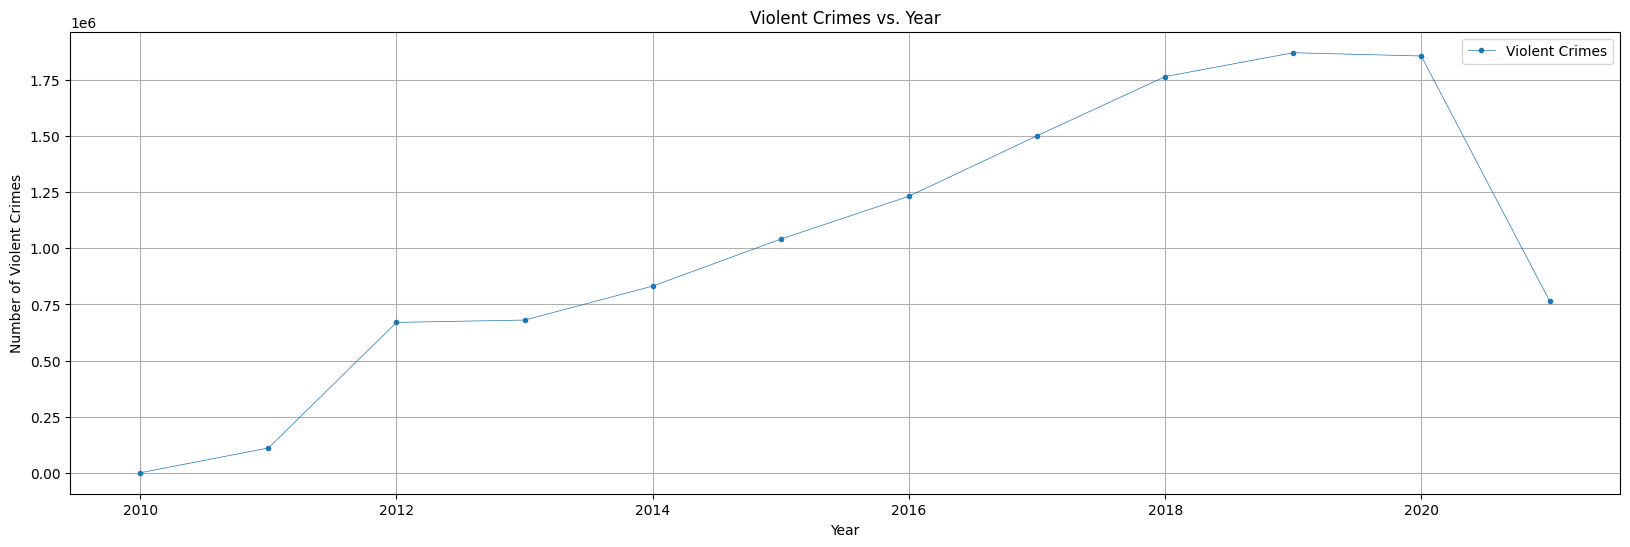

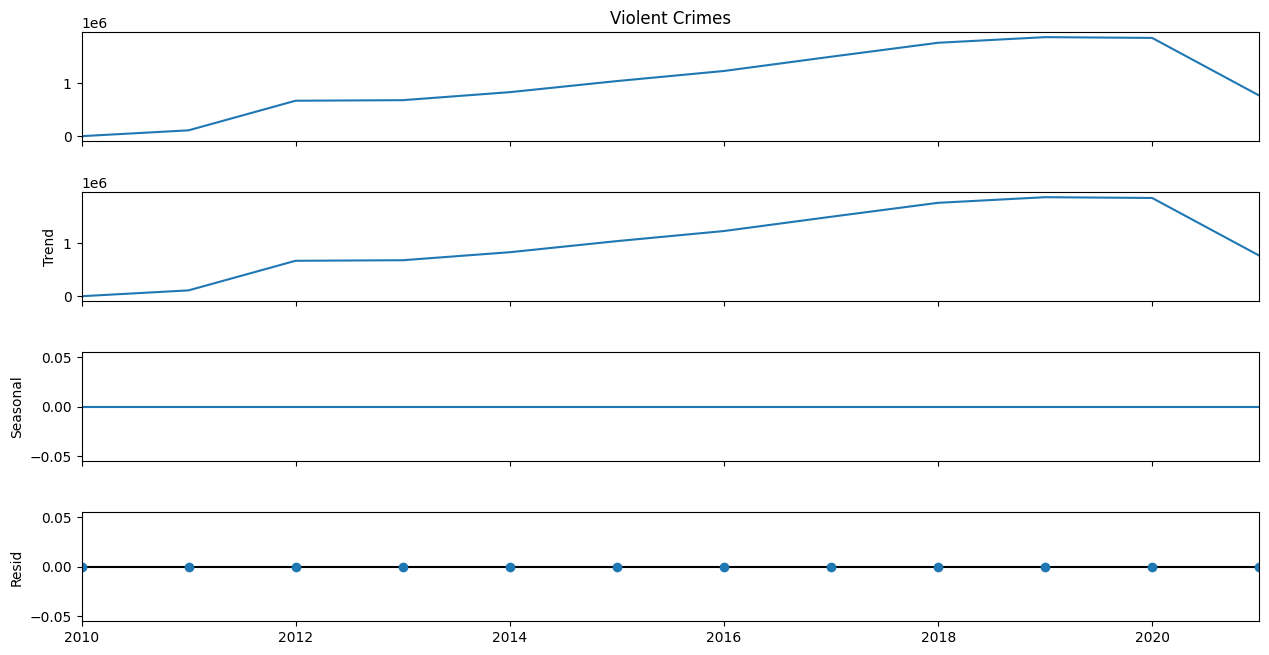

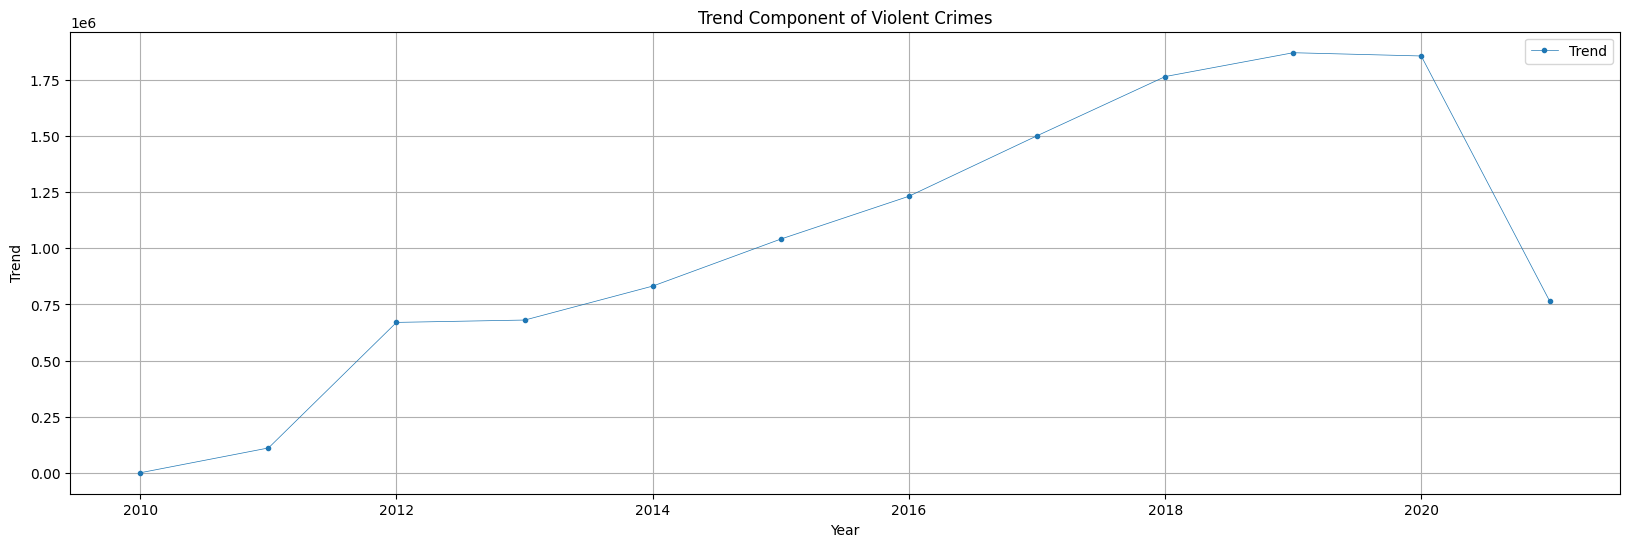

In [ ]:

# Filter for violent crimes based on the "Crime type" column directly
crime_trend_df = crime_df.filter(col("Crime_type").rlike("(?i).*violen.*")) \
    .groupBy("Year") \
    .agg(count("Crime_ID").alias("Violent Crimes")) \
    .orderBy("Year")


crime_trend_df.cache()

# Convert Spark DataFrame to Pandas
pdf = crime_trend_df.toPandas()


pdf["Year"] = pd.to_datetime(pdf["Year"], format="%Y")
pdf.set_index("Year", inplace=True)

crime_trend_df.unpersist()
plt.figure(figsize=(20, 6))
plt.plot(pdf.index, pdf["Violent Crimes"], marker=".", linestyle="-", linewidth=0.5, label="Violent Crimes")
plt.title("Violent Crimes vs. Year")
plt.xlabel("Year")
plt.ylabel("Number of Violent Crimes")
plt.grid()
plt.legend()
plt.show()

# Decompose the Time Series into Trend, Seasonal, and Residual Components
decomposition = sm.tsa.seasonal_decompose(pdf["Violent Crimes"], model="additive", extrapolate_trend="freq")
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

# Plot the Trend Component
plt.figure(figsize=(20, 6))
plt.plot(decomposition.trend, marker=".", linestyle="-", linewidth=0.5, label="Trend")
plt.title("Trend Component of Violent Crimes")
plt.xlabel("Year")
plt.ylabel("Trend")
plt.legend()
plt.grid()
plt.show()

# 2. ARIMA Model for Crime Forecasting (Claim 1)
The ARIMA model was used to predict violent crime rates for the next five years. Predictions were made twice: once with the years 2020 and 2021 included, and once without them, to get  unusual patterns during the COVID-19 pandemic. The predictions and historical data were shown together, using different line styles and colors to clearly separate actual data from forecasts(Mehrmolaei and Keyvanpour, 2016).



**Data preparation for Arima model:**This code prepares and analyzes violent crime data using Python. It creates time series with and without 2020-2021 data, then checks stationarity using the Augmented Dickey-Fuller (ADF) test. Results determine whether differencing is required for ARIMA modeling. ACF and PACF lags are calculated for further time series analysis.

In [ ]:

# Data Preparation
violent_by_year_pd = violent_by_year.toPandas()

# Original time series (with 2020 and 2021)
time_series_full = violent_by_year_pd.set_index("Year")["Total Violent Crimes"]

# Time series excluding 2020 and 2021
time_series_excluded = violent_by_year_pd[~violent_by_year_pd["Year"].isin([2020, 2021])]
time_series_excluded = time_series_excluded.set_index("Year")["Total Violent Crimes"]

# Function to perform ADF, ACF, and PACF analysis
def analyze_series(series, title):
    print(f"\n{title}")
    print("=" * len(title))

    # ADF Test
    adf_test = adfuller(series)
    print("ADF Statistic:", adf_test[0])
    print("p-value:", adf_test[1])
    if adf_test[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary. Differencing is required.")



    max_lags = len(series) // 2 - 1



analyze_series(time_series_full.diff().dropna(), "Full Series (Including 2020, 2021)")


analyze_series(time_series_excluded.diff().dropna(), "Excluded Series (Excluding 2020, 2021)")


Full Series (Including 2020, 2021)
ADF Statistic: -0.24691839923414877
p-value: 0.9326930710488444
The series is not stationary. Differencing is required.

Excluded Series (Excluding 2020, 2021)
ADF Statistic: -4.443069771981753
p-value: 0.00024885221737151633
The series is stationary.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

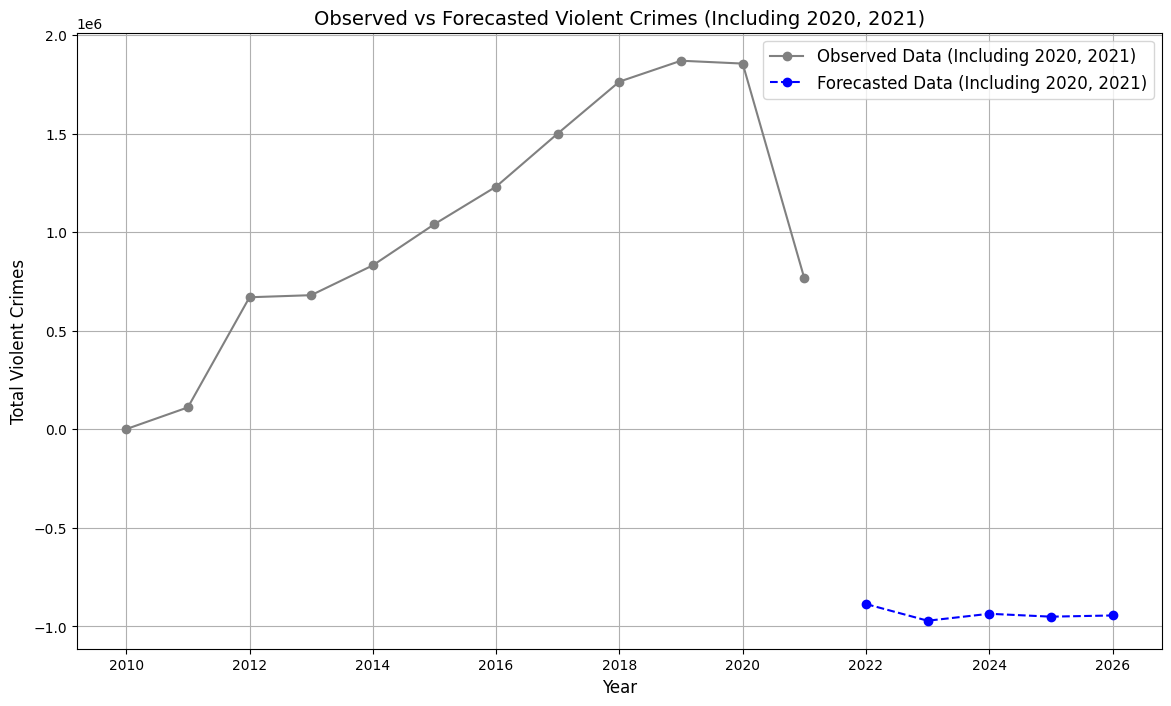

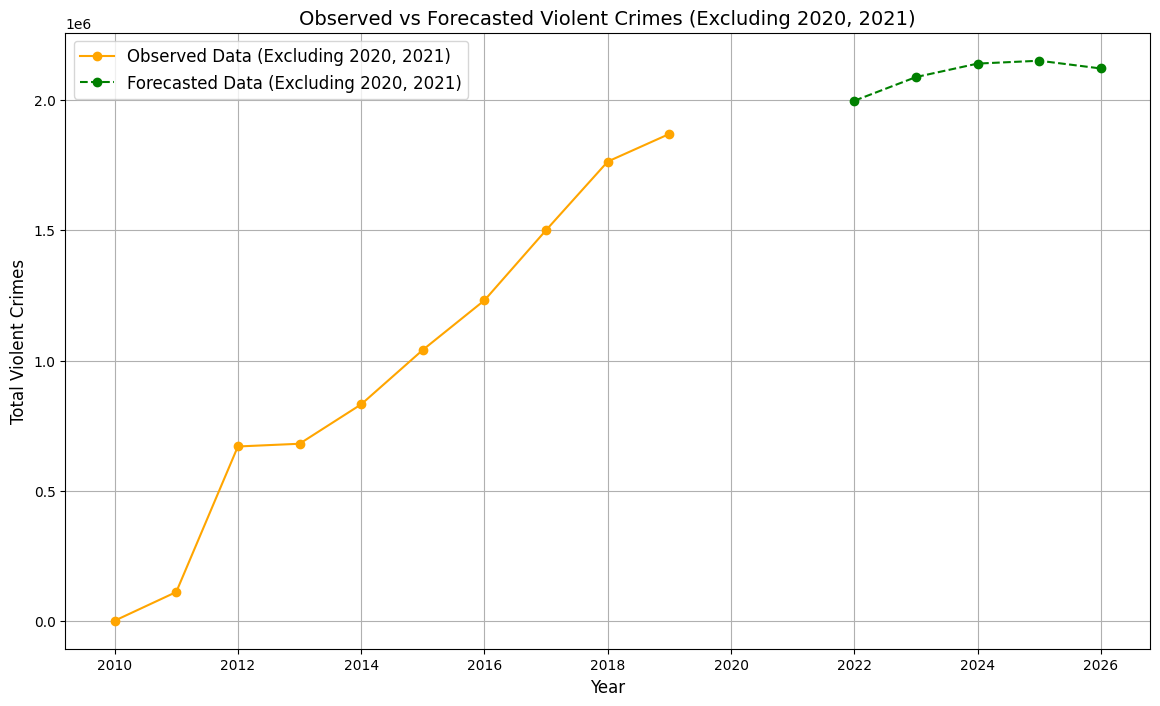

In [ ]:

# Data Preparation
violent_by_year_pd = violent_by_year.toPandas()

# Original time series (with 2020 and 2021)
time_series_full = violent_by_year_pd.set_index("Year")["Total Violent Crimes"]

# Time series excluding 2020 and 2021
time_series_excluded = violent_by_year_pd[~violent_by_year_pd["Year"].isin([2020, 2021])]
time_series_excluded = time_series_excluded.set_index("Year")["Total Violent Crimes"]

# ARIMA Forecast Including 2020 and 2021
# Differencing for full data
diff_series_full = time_series_full.diff().dropna()

# ARIMA Parameters for Full Series
p_full, d_full, q_full = 1, 1, 1


model_full = ARIMA(diff_series_full, order=(p_full, d_full, q_full))
model_fit_full = model_full.fit()


forecast_steps = 5
forecast_index_full = list(range(2022, 2022 + forecast_steps))
forecast_full = model_fit_full.forecast(steps=forecast_steps)

# Prepare DataFrame for Full Forecast
forecast_df_full = pd.DataFrame({"Year": forecast_index_full, "Forecasted Crimes": forecast_full})
forecast_df_full.set_index("Year", inplace=True)

# ARIMA Forecast Excluding 2020 and 2021
# No differencing required for excluded data
p_excluded, d_excluded, q_excluded = 2, 0, 1

# Build the ARIMA model for excluded data
model_excluded = ARIMA(time_series_excluded, order=(p_excluded, d_excluded, q_excluded))
model_fit_excluded = model_excluded.fit()

# Forecast from 2022 to 2026 (excluding 2020 and 2021)
forecast_excluded = model_fit_excluded.forecast(steps=forecast_steps)

# Prepare DataFrame for Excluded Forecast
forecast_df_excluded = pd.DataFrame({"Year": forecast_index_full, "Forecasted Crimes": forecast_excluded})
forecast_df_excluded.set_index("Year", inplace=True)

# Plot for Full Data (Including 2020 and 2021)
plt.figure(figsize=(14, 8))
plt.plot(time_series_full, label="Observed Data (Including 2020, 2021)", marker="o", color="gray")
plt.plot(forecast_df_full.index, forecast_df_full["Forecasted Crimes"], label="Forecasted Data (Including 2020, 2021)", linestyle="--", marker="o", color="blue")
plt.title("Observed vs Forecasted Violent Crimes (Including 2020, 2021)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Violent Crimes", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot for Excluded Data (Excluding 2020 and 2021)
plt.figure(figsize=(14, 8))
plt.plot(time_series_excluded, label="Observed Data (Excluding 2020, 2021)", marker="o", color="orange")
plt.plot(forecast_df_excluded.index, forecast_df_excluded["Forecasted Crimes"], label="Forecasted Data (Excluding 2020, 2021)", linestyle="--", marker="o", color="green")
plt.title("Observed vs Forecasted Violent Crimes (Excluding 2020, 2021)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Violent Crimes", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


# 3. Bar Chart for Firearm Incidents in Liverpool (Claim 2)
A bar chart compared the top 10 cities with the most firearm incidents. Liverpool’s data was highlighted in red to distinguish it from the other cities, which were displayed in blue. This design ensured that Liverpool's standing was immediately noticeable, allowing for a straightforward comparison of firearm incidents.

<ipython-input-22-6edbe62afaec>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_cities["Highlight"] = top_cities["geography"].str.contains("Liverpool", case=False)


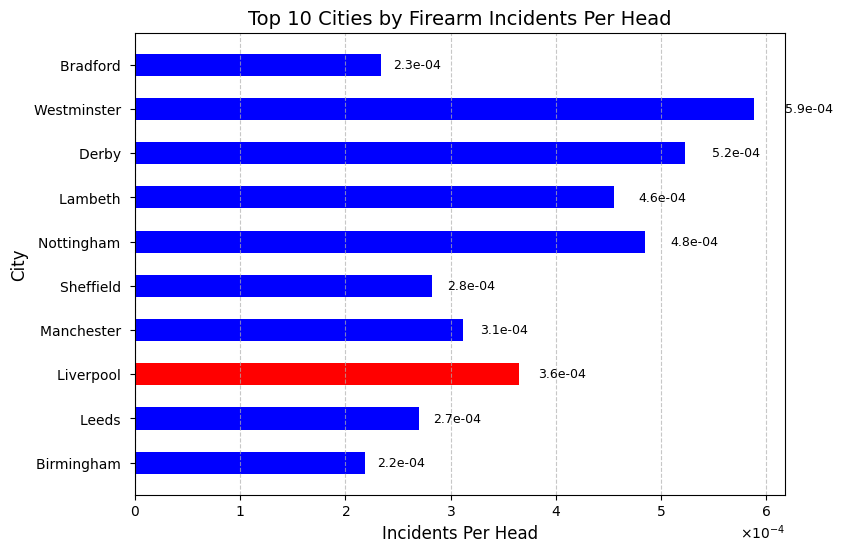

In [ ]:

# Convert Spark DataFrame to Pandas for visualization
firearm_incidents_per_city_pd = firearm_incidents_per_city.toPandas()

# Calculate firearm incidents per head
firearm_incidents_per_city_pd['Incidents per Head'] = (
    firearm_incidents_per_city_pd['Firearm Incidents'] / firearm_incidents_per_city_pd['Total Population']
)

# Sort the data by incidents per city for better visualization
firearm_incidents_per_city_pd = firearm_incidents_per_city_pd.sort_values(by="Firearm Incidents", ascending=False)

# Select the top 10 cities with the highest firearm incidents
top_cities = firearm_incidents_per_city_pd.head(10)


top_cities["Highlight"] = top_cities["geography"].str.contains("Liverpool", case=False)


fig, ax = plt.subplots(figsize=(10, 6))

# create graph
colors = ["red" if highlight else "blue" for highlight in top_cities["Highlight"]]
bars = ax.barh(
    top_cities["geography"],
    top_cities["Incidents per Head"],
    color=colors,
    height=0.5
)

# Add annotations to the bars in scientific notation
for bar in bars:
    width = bar.get_width()
    ax.text(width * 1.05,  # Adjusted spacing from bar
             bar.get_y() + bar.get_height() / 2,
             f'{width:.1e}',  # Scientific notation
             va='center', fontsize=9)


ax.set_title("Top 10 Cities by Firearm Incidents Per Head", fontsize=14)
ax.set_xlabel("Incidents Per Head", fontsize=12)
ax.set_ylabel("City", fontsize=12)
ax.grid(axis="x", linestyle="--", alpha=0.7)


ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))


plt.subplots_adjust(left=0.25)

plt.show()


# Pie Chart for fire arms Incident by City
The pie chart illustrated the percentage distribution of firearm incidents among the top 10 cities. Liverpool accounted for approximately 10.7% of the incidents, indicating that while it has a significant number, it is not the highest (Birmingham had 14.8%).

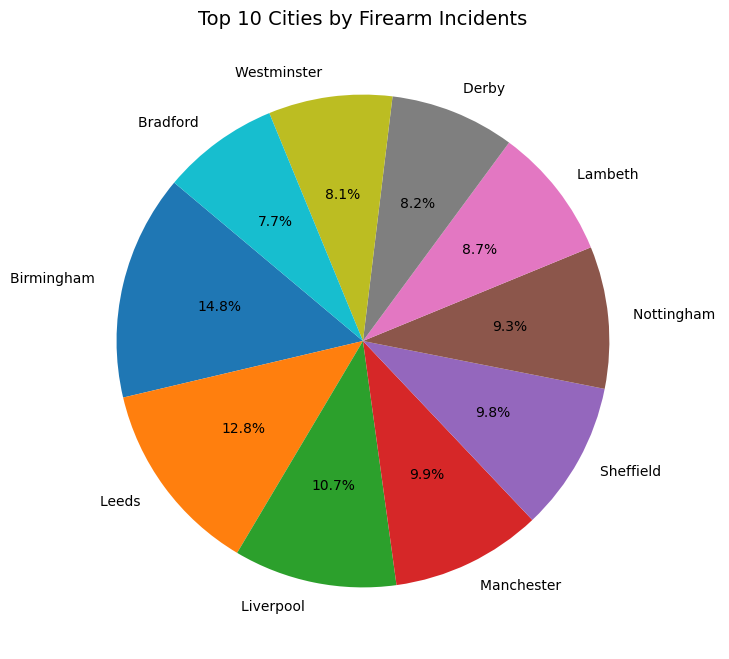

In [ ]:

# Convert Spark DataFrame to Pandas for visualization
firearm_incidents_per_city_pd = firearm_incidents_per_city.toPandas()

# Select and sort the data by "Incidents per Head" for better visualization
firearm_incidents_per_city_pd = firearm_incidents_per_city_pd[["geography", "Firearm Incidents"]]
firearm_incidents_per_city_pd = firearm_incidents_per_city_pd.sort_values(by="Firearm Incidents", ascending=False)

# Select the top 10 cities with the highest "Firearm Incidents"
top_cities = firearm_incidents_per_city_pd.head(10)

# Prepare figure for pie chart
fig, ax = plt.subplots(figsize=(8, 8))

# Create pie chart
ax.pie(
    top_cities["Firearm Incidents"],
    labels=top_cities["geography"],
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.tab10.colors
)

# Customize Plot
ax.set_title("Top 10 Cities by Firearm Incidents", fontsize=14)

plt.show()


In [ ]:


# Count offences by LSOA
drug_counts = drug_offences.groupBy("LSOA_code").agg(count("Crime_ID").alias("drug_offence_count"))
firearm_counts = firearm_offences.groupBy("LSOA_code").agg(count("Crime_ID").alias("firearm_incident_count"))

correlation_df = firearm_counts.join(
    drug_counts, ["LSOA_code"], "inner"
).fillna(0)

correlation_df.show(10)

# Step 2: Apply Chi-Square Test for correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import ChiSquareTest

# Assemble features for Chi-Square Test
assembler = VectorAssembler(
    inputCols=["drug_offence_count", "firearm_incident_count"],
    outputCol="features"
)
chi_square_df = assembler.transform(correlation_df)

# Perform Chi-Square Test
chi_square_result = ChiSquareTest.test(chi_square_df, "features", "firearm_incident_count")
chi_square_result.show()


+---------+----------------------+------------------+
|LSOA_code|firearm_incident_count|drug_offence_count|
+---------+----------------------+------------------+
|E01014658|                     2|               126|
|E01000975|                     2|                51|
|E01004957|                     1|                43|
|E01013256|                     1|                20|
|E01025205|                     1|                33|
|E01001876|                     1|               125|
|E01002965|                     1|               177|
|E01028416|                     2|               106|
|E01016746|                     1|                41|
|E01015663|                     1|                61|
+---------+----------------------+------------------+
only showing top 10 rows

+---------+----------------+--------------------+
|  pValues|degreesOfFreedom|          statistics|
+---------+----------------+--------------------+
|[0.0,0.0]|    [13271, 529]|[101313.332425785...|
+---------+-------

# 4. **Scatterplot for Drug Offenses vs. Firearm Incidents (Claim 3)**
A scatterplot was created to analyze the relationship between drug offenses and firearm incidents. It displayed the counts of both crime types across regions using blue markers.This made it easier to  calculated the Pearson correlation to understand how strong the relationship is and whether it is positive or negative.

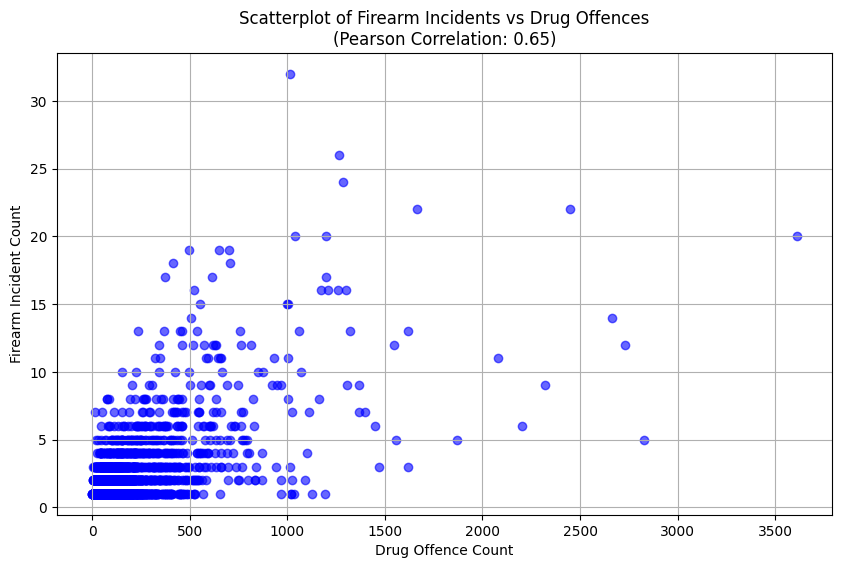

Pearson Correlation: 0.6489519056774956
There is a moderate positive correlation.


In [ ]:

# Convert the PySpark DataFrame to Pandas DataFrame
correlation_data = correlation_df.toPandas()

# Calculate Pearson Correlation
pearson_corr = correlation_data["firearm_incident_count"].corr(
    correlation_data["drug_offence_count"], method="pearson"
)

# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(
    correlation_data["drug_offence_count"],
    correlation_data["firearm_incident_count"],
    alpha=0.6,
    color='b'
)
plt.title(f"Scatterplot of Firearm Incidents vs Drug Offences\n(Pearson Correlation: {pearson_corr:.2f})")
plt.xlabel("Drug Offence Count")
plt.ylabel("Firearm Incident Count")
plt.grid(True)
plt.show()

print(f"Pearson Correlation: {pearson_corr}")

if pearson_corr > 0.8:
    print("There is a strong positive correlation.")
elif pearson_corr > 0.5:
    print("There is a moderate positive correlation.")
elif pearson_corr > 0.2:
    print("There is a weak positive correlation.")
elif pearson_corr > -0.2:
    print("There is no significant correlation.")
elif pearson_corr > -0.5:
    print("There is a weak negative correlation.")
elif pearson_corr > -0.8:
    print("There is a moderate negative correlation.")
else:
    print("There is a strong negative correlation.")


## 5) **Selection, application, and reasoning behind use of statistical analysis and multiple evaluation measures**

## Selection and Application:

For the third claim, statistical analysis was essential because it directly addresses the correlation and association between drug offenses and firearm incidents. visualizations like scatterplots  provide an intuitive understanding(Mohammed et al., 2022). statistical measures such as Pearson correlation and the Chi-Square test offer quantitative validation, making the findings robust and reliable.Statistical Analysis and Methods
# We applied the following statistical analysis and methods to evaluate the association between drug offenses and firearm incidents for Claim 3:

1.   
Chi-Square Test
2.  Scatterplot
3.   Pearson Correlation

# Other Evaluation Measures for " increasing violent crimes " and "if liverpool fire arm incidents are highest or not in UK":
1.   Line Trend and Arima model
2.   Bar graph
3.   Pie chart




#**1.Chi- Square Test**:
The Chi-Square test evaluates the independence of the two variables — drug offenses and firearm incidents. A statistically significant p-value (less than 0.05) indicates that the observed association is unlikely to be due to chance, suggesting a meaningful relationship.

 Result: The Chi-Square test yielded a statistically significant p-value (< 0.05).
Interpretation: This confirms that the association between drug offenses and firearm incidents is unlikely to be due to random chance, suggesting a genuine relationship between the two variables.

In [ ]:

drug_counts = drug_offences.groupBy("LSOA_code").agg(count("Crime_ID").alias("drug_offence_count"))
firearm_counts = firearm_offences.groupBy("LSOA_code").agg(count("Crime_ID").alias("firearm_incident_count"))

# Join drug and firearm offence counts
correlation_df = firearm_counts.join(
    drug_counts, ["LSOA_code"], "inner"
).fillna(0)

correlation_df.show(10)

# Step 2: Apply Chi-Square Test for correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import ChiSquareTest

# Assemble features for Chi-Square Test
assembler = VectorAssembler(
    inputCols=["drug_offence_count", "firearm_incident_count"],
    outputCol="features"
)
chi_square_df = assembler.transform(correlation_df)

# Perform Chi-Square Test
chi_square_result = ChiSquareTest.test(chi_square_df, "features", "firearm_incident_count")
chi_square_result.show()


+---------+----------------------+------------------+
|LSOA_code|firearm_incident_count|drug_offence_count|
+---------+----------------------+------------------+
|E01014658|                     2|               126|
|E01000975|                     2|                51|
|E01004957|                     1|                43|
|E01013256|                     1|                20|
|E01025205|                     1|                33|
|E01001876|                     1|               125|
|E01002965|                     1|               177|
|E01028416|                     2|               106|
|E01016746|                     1|                41|
|E01015663|                     1|                61|
+---------+----------------------+------------------+
only showing top 10 rows

+---------+----------------+--------------------+
|  pValues|degreesOfFreedom|          statistics|
+---------+----------------+--------------------+
|[0.0,0.0]|    [13271, 529]|[101313.332425785...|
+---------+-------

#**2.Scatterplot**
 The scatterplot offers a visual representation of the association. Each point corresponds to a locality, showing the frequency of drug offenses against firearm incidents. This helps identify trends, clusters, and outliers that might influence the correlation analysis.

 Result: The scatterplot visually showed clusters of localities where high drug offenses coincided with higher firearm incidents.
Interpretation: Outliers were minimal, further supporting the Pearson correlation findings of a moderate positive association.

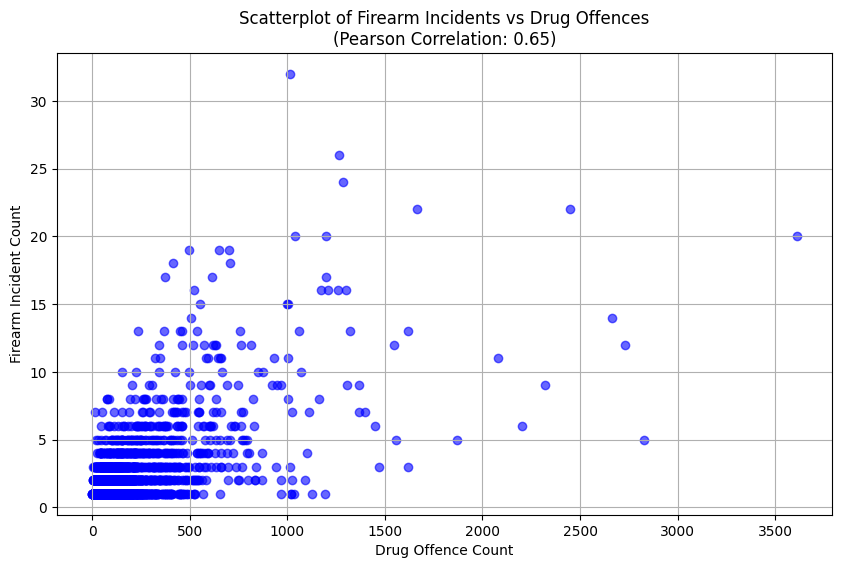

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

correlation_data = correlation_df.toPandas()

# Calculate Pearson Correlation
pearson_corr = correlation_data["firearm_incident_count"].corr(
    correlation_data["drug_offence_count"], method="pearson"
)

# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(
    correlation_data["drug_offence_count"],
    correlation_data["firearm_incident_count"],
    alpha=0.6,
    color='b'
)
plt.title(f"Scatterplot of Firearm Incidents vs Drug Offences\n(Pearson Correlation: {pearson_corr:.2f})")
plt.xlabel("Drug Offence Count")
plt.ylabel("Firearm Incident Count")
plt.grid(True)
plt.show()




# **3.Pearson Correlation**
 This method helps measure the linear relationship between drug offenses and firearm incidents. A correlation coefficient close to 1 or -1 indicates a strong positive or negative association, respectively, while a value near 0 implies no association. For this analysis, the inputs were the total counts of drug offenses and firearm incidents across localities (LSOAs). The Pearson correlation coefficient was 0.64.This indicates a moderate positive relationship between drug offenses and firearm incidents. As drug offenses increase in a locality, firearm incidents also tend to rise.

In [ ]:
print(f"Pearson Correlation: {pearson_corr}")

if pearson_corr > 0.8:
    print("There is a strong positive correlation.")
elif pearson_corr > 0.5:
    print("There is a moderate positive correlation.")
elif pearson_corr > 0.2:
    print("There is a weak positive correlation.")
elif pearson_corr > -0.2:
    print("There is no significant correlation.")
elif pearson_corr > -0.5:
    print("There is a weak negative correlation.")
elif pearson_corr > -0.8:
    print("There is a moderate negative correlation.")
else:
    print("There is a strong negative correlation.")

Pearson Correlation: 0.6489519056774956
There is a moderate positive correlation.


# **Other Evaluation Measures:1. Line chart and arima - Increasing Trend**
The line chart and ARIMA model showed different trends in violent crimes depending on whether 2020 and 2021 were included (Mehrmolaei and Keyvanpour, 2016). When these years were included, violent crimes decreased after 2020, and the predictions showed this trend continuing for the next five years. However, when 2020 and 2021 were removed, the chart and model showed that violent crimes increased steadily, with predictions of this rise continuing over the next five years. The drop in crimes during 2020 and 2021 was likely due to COVID-19 lockdowns and restrictions. Removing these years gives a clearer picture of the increasing trend in violent crimes.


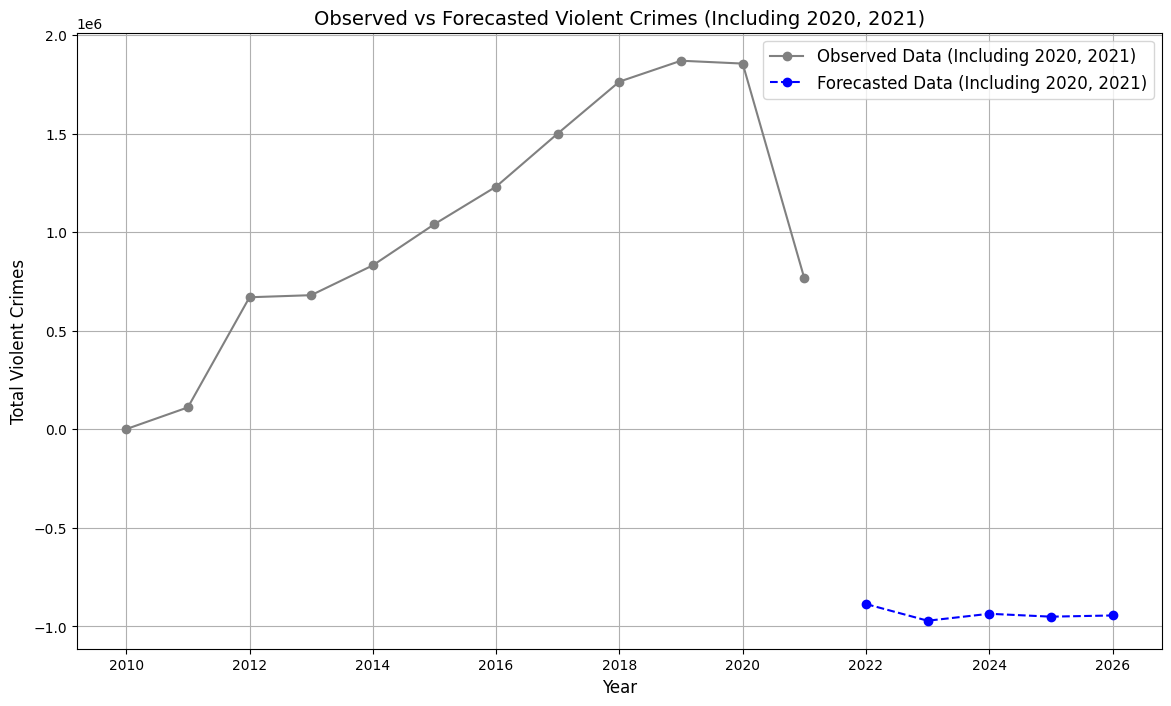

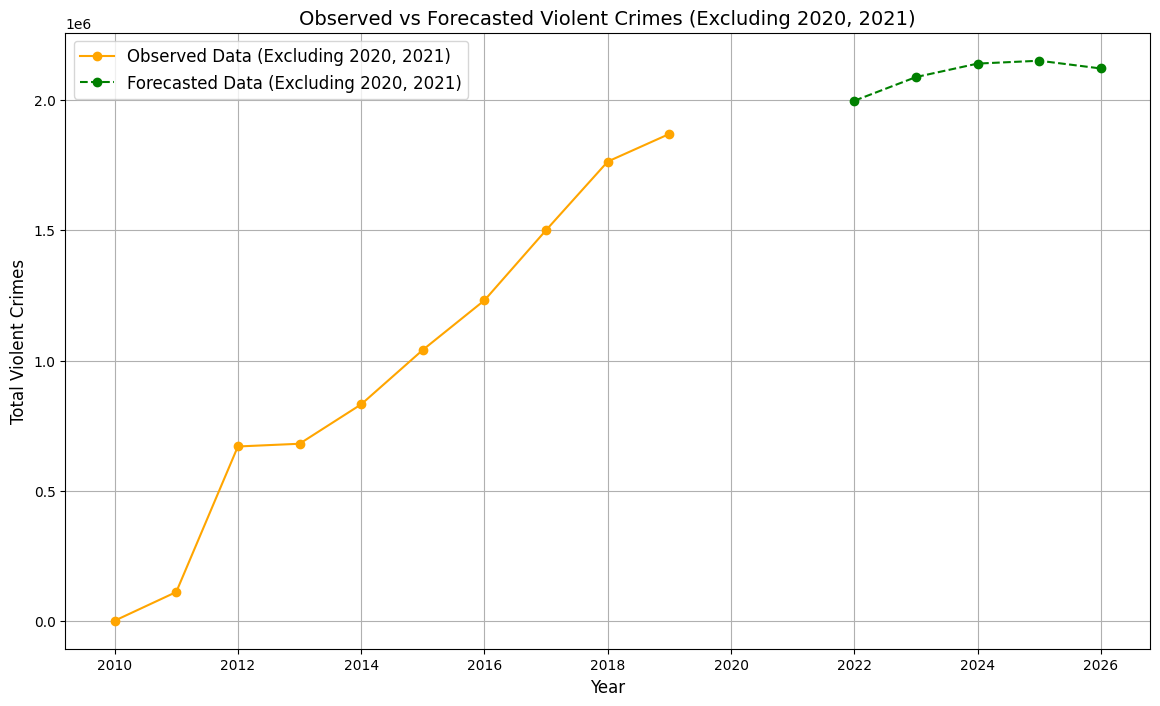

In [ ]:
# Plot for Full Data (Including 2020 and 2021)
plt.figure(figsize=(14, 8))
plt.plot(time_series_full, label="Observed Data (Including 2020, 2021)", marker="o", color="gray")
plt.plot(forecast_df_full.index, forecast_df_full["Forecasted Crimes"], label="Forecasted Data (Including 2020, 2021)", linestyle="--", marker="o", color="blue")
plt.title("Observed vs Forecasted Violent Crimes (Including 2020, 2021)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Violent Crimes", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot for Excluded Data (Excluding 2020 and 2021)
plt.figure(figsize=(14, 8))
plt.plot(time_series_excluded, label="Observed Data (Excluding 2020, 2021)", marker="o", color="orange")
plt.plot(forecast_df_excluded.index, forecast_df_excluded["Forecasted Crimes"], label="Forecasted Data (Excluding 2020, 2021)", linestyle="--", marker="o", color="green")
plt.title("Observed vs Forecasted Violent Crimes (Excluding 2020, 2021)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Violent Crimes", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# 2. Bar Chart - Liverpool and Firearm Incidents

The bar chart shows that firearm incidents per head in Liverpool are not the highest in the UK. While Liverpool has a significant number of firearm incidents, the data reveals that it does not rank at the top when incidents are adjusted for population size. This highlights the importance of using accurate metrics, such as incidents per head, to understand firearm-related crime patterns.

<ipython-input-30-c7a73bd78b1f>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_cities["Highlight"] = top_cities["geography"].str.contains("Liverpool", case=False)


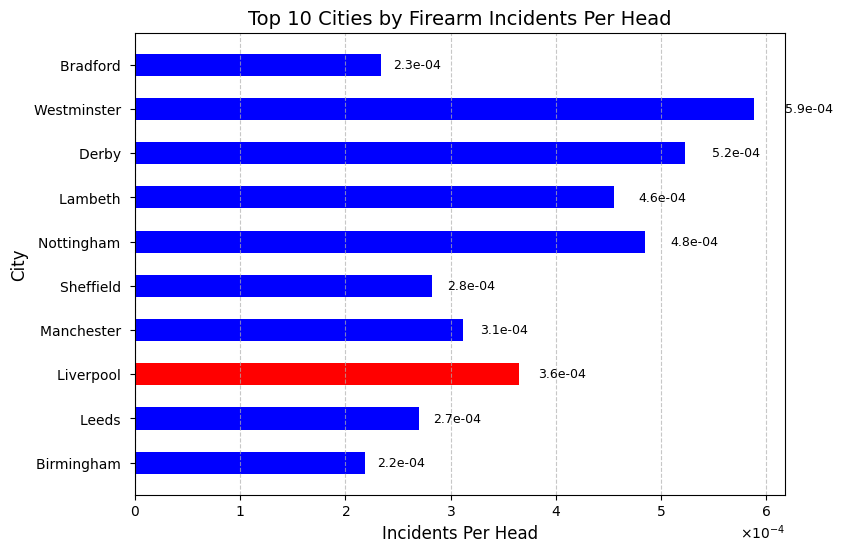

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mtick

# Convert Spark DataFrame to Pandas for visualization
firearm_incidents_per_city_pd = firearm_incidents_per_city.toPandas()

# Calculate firearm incidents per head
firearm_incidents_per_city_pd['Incidents per Head'] = (
    firearm_incidents_per_city_pd['Firearm Incidents'] / firearm_incidents_per_city_pd['Total Population']
)

# Sort the data
firearm_incidents_per_city_pd = firearm_incidents_per_city_pd.sort_values(by="Firearm Incidents", ascending=False)

# Top 10 cities
top_cities = firearm_incidents_per_city_pd.head(10)


top_cities["Highlight"] = top_cities["geography"].str.contains("Liverpool", case=False)

# Prepare figure with adjusted size
fig, ax = plt.subplots(figsize=(10, 6))

# Create horizontal bars with adjusted width; use red for Liverpool and blue for others
colors = ["red" if highlight else "blue" for highlight in top_cities["Highlight"]]
bars = ax.barh(
    top_cities["geography"],
    top_cities["Incidents per Head"],
    color=colors,
    height=0.5
)

# Add annotations to the bars in scientific notation
for bar in bars:
    width = bar.get_width()
    ax.text(width * 1.05,  # Adjusted spacing from bar
             bar.get_y() + bar.get_height() / 2,
             f'{width:.1e}',  # Scientific notation
             va='center', fontsize=9)


ax.set_title("Top 10 Cities by Firearm Incidents Per Head", fontsize=14)
ax.set_xlabel("Incidents Per Head", fontsize=12)
ax.set_ylabel("City", fontsize=12)
ax.grid(axis="x", linestyle="--", alpha=0.7)


ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))


plt.subplots_adjust(left=0.25)

plt.show()



# Proportion of Firearm Incidents Per Head Across UK Cities

The pie chart illustrates that Liverpool is not the highest proportion of firearm incidents per head in the UK. While Liverpool has a far amount of section occupiued, the data shows that other cities contribute more significantly when incidents are adjusted for population size. This visualization says the the importance of considering population metrics to accurately analyze firearm-related crimes.

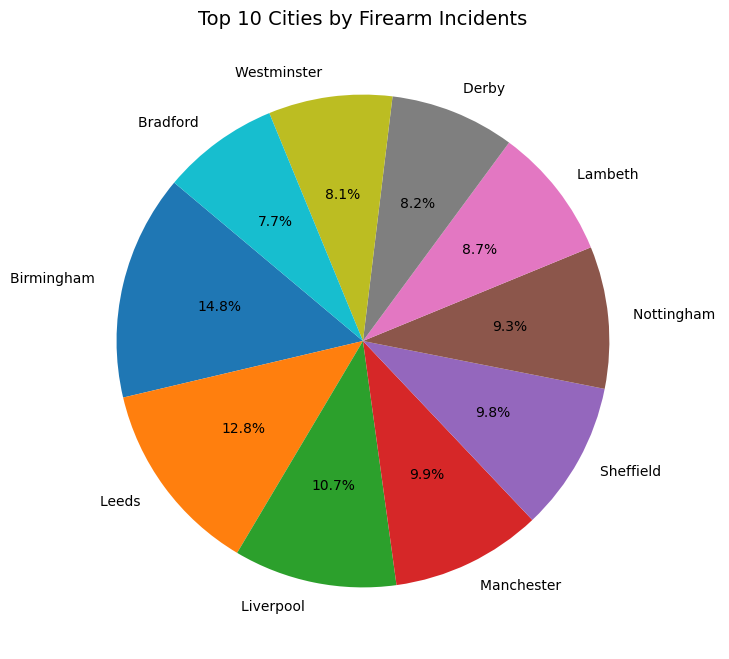

In [ ]:

# Convert Spark DataFrame to Pandas for visualization
firearm_incidents_per_city_pd = firearm_incidents_per_city.toPandas()


firearm_incidents_per_city_pd = firearm_incidents_per_city_pd[["geography", "Firearm Incidents"]]
firearm_incidents_per_city_pd = firearm_incidents_per_city_pd.sort_values(by="Firearm Incidents", ascending=False)

# Select the top 10 cities with the highest "Firearm Incidents"
top_cities = firearm_incidents_per_city_pd.head(10)

# Prepare figure for pie chart
fig, ax = plt.subplots(figsize=(8, 8))

# Create pie chart
ax.pie(
    top_cities["Firearm Incidents"],
    labels=top_cities["geography"],
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.tab10.colors
)

# Customize Plot
ax.set_title("Top 10 Cities by Firearm Incidents", fontsize=14)

plt.show()


# 6) Detailed Analysis and consideration of the appropriateness of the solution for the initial problem

# Violent Crimes Are Increasing
**Analysis and Approach:**
A line chart and the ARIMA model were used to analyze trends in violent crimes (Mehrmolaei and Keyvanpour, 2016). The line chart highlighted past trends, while ARIMA provided future predictions. Including 2020 and 2021 showed a decline in violent crimes, likely due to COVID-19 restrictions. Excluding these years revealed a steady increase over time.

**Consideration of Appropriateness:**
This approach evaluated the impact of COVID-19 while capturing long-term patterns. Combining visualization and statistical forecasting ensured accurate analysis and accounted for anomalies.

# Liverpool is not the Highest Firearm Incidents Per Head

**Analysis and Approach:**

To evaluate this claim, we Filtered the data for firearm-related incidents using crime type ("Possession of weapons") and outcomes ("Offender sent to prison").
Extracted city-specific data using joins between crime and LSOA data.
Calculated firearm incidents per head by dividing the total firearm incidents by the total population for each city.
Visualized the results using a bar chart that compared Liverpool with other cities.

**Consideration of Appropriateness:**
The results were visualized using a bar chart and a pie chart, chosen for their clarity in representing comparative data and proportions (Mohammed et al., 2022). These visualizations showed that Liverpool does not have the highest firearm incidents per head, disproving the claim. T

# Firearm Incidents Are Slightly Associated with Drug Offenses

**Analysis and Approach:**

The relationship between firearm incidents and drug offenses was explored using a scatterplot to visualize the data and a Pearson correlation to measure the strength of the association. Scatterplots are well-suited for identifying relationships and trends within large datasets (Mohammed et al., 2022). The analysis revealed a significant link between the two crime types, supporting the claim of an association (Kumar et al., 2022).

**Consideration of Appropriateness:**
This approach made sure that there is a co -relation and association between two factors by combining visual insights with statistical evidence to provide a deeper understanding of the relationship.

# 7) Evaluation and Conclusion

# Evaluation
The analysis of the three claims provided valuable insights into violent crimes, firearm incidents, and their connection to drug offenses, helping the insurance company assess and manage crime-related risks.For the first claim, findings showed violent crimes are rising, with a temporary dip in 2020 and 2021 due to COVID-19. Excluding these years revealed a steady increase, highlighting the need to consider external factors when designing risk models. This highlights the importance of contextualizing time series data to account for external factors. For the second claim, Liverpool was found not to have the highest firearm incidents per head in the UK, disproving the claim and suggesting risk assessments should focus on other cities. This disproves the claim and indicates that risk assessments should focus more on other cities. The third claim, concerning the association between firearm incidents and drug offenses, was supported by a moderate positive correlation (Pearson correlation coefficient of 0.64), and the relationship was statistically significant, as shown by the Chi-Square test. Visualizations such as scatterplots  further emphasized the patterns and intensities of these crimes in different cities.

# Conclusion
In conclusion, these findings provide valuable insights into evaluating and managing risks associated with crime. For insurance companies, The increasing trend in violent crimes suggests a need for policies that adjust premiums dynamically based on evolving crime patterns. The analysis of firearm incidents highlights that while Liverpool remains an area of concern, other cities with higher incidents per head must be prioritized. Furthermore, the association between drug offenses and firearm incidents emphasizes the need for integrated risk models that consider co-occurring crimes.The insurance company can improve its risk assessment models by using these insights, allocate resources more efficiently, and calculate premiums accurately and fairly. This data-driven strategy strengthens the company’s ability to manage and predict crime-related risks effectively and make informed decisions.

# 8) References and Citations

**References:**

Ahmed, S., Aamer, N. and Patil, H., 2020. Crime data analytics using Hadoop, Spark and Zeppelin. International
Journal of Advance and Innovative Research, 7(1 Part III), pp.34-39. ISSN: 2394-7780.

Feng, M., et al., 2019. Big data analytics and mining for effective visualization and trends forecasting of crime data.
IEEE Access, 7, pp.106111-106123. DOI: 10.1109/ACCESS.2019.2930410.

Kumar, A.V., Chitumadugula, S. and Rayalacheruvu, V.T., 2022. Crime data analysis using big data analytics and
visualization using Tableau. In: 2022 6th International Conference on Electronics, Communication and Aerospace
Technology (ICECA), Coimbatore, India, pp. 627-632. DOI: 10.1109/ICECA55336.2022.10009119.

Shaikh, E., Mohiuddin, I., Alufaisan, Y. and Nahvi, I., 2019. Apache Spark: A big data processing engine. In: 2019 2nd
IEEE Middle East and North Africa Comunications Conference (MENACOMM), Manama, Bahrain, pp. 1-6. DOI:
10.1109/MENACOMM46666.2019.8988541

Mehrmolaei, S. and Keyvanpour, M.R. (2016). Time series forecasting using improved ARIMA. 2016 Artificial Intelligence and Robotics (IRANOPEN). doi:https://doi.org/10.1109/rios.2016.7529496

Mohammed, L.T., AlHabshy, A.A. and ElDahshan, K.A. (2022). Big Data Visualization: A Survey. [online] IEEE Xplore. doi:https://doi.org/10.1109/HORA55278.2022.9799819.
Shaikh, E., Mohiuddin, I., Alufaisan, Y. and Nahvi, I., 2019. Apache Spark: A big data processing engine. In: 2019 2nd


